In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
train = pd.read_csv('data/cs-training.csv',index_col = 0)
test = pd.read_csv('data/cs-test.csv',index_col = 0)


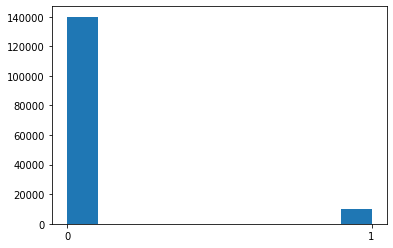

In [3]:
# imbalance traget data
plt.hist(train['SeriousDlqin2yrs'])
plt.xticks(np.arange(0, 1.1,1))
plt.show()

In [4]:
def plot_axes(data,mode=None):
    n_row = data.columns[1:].shape[0]
    fig = plt.figure(figsize = [15, 5 * n_row])
    
    if mode == 'box':
        for i,j in enumerate(data.columns[1:]):
            ax = fig.add_subplot(n_row,2,i+1)

            ax.boxplot(data.loc[:,j])
            ax.set_title(j)
            
    else:
        for i,j in enumerate(train.columns[1:]):
            ax = fig.add_subplot(n_row,2,i+1)

            ax.plot(data.loc[:,j],'.')
            ax.set_title(j)
            
    

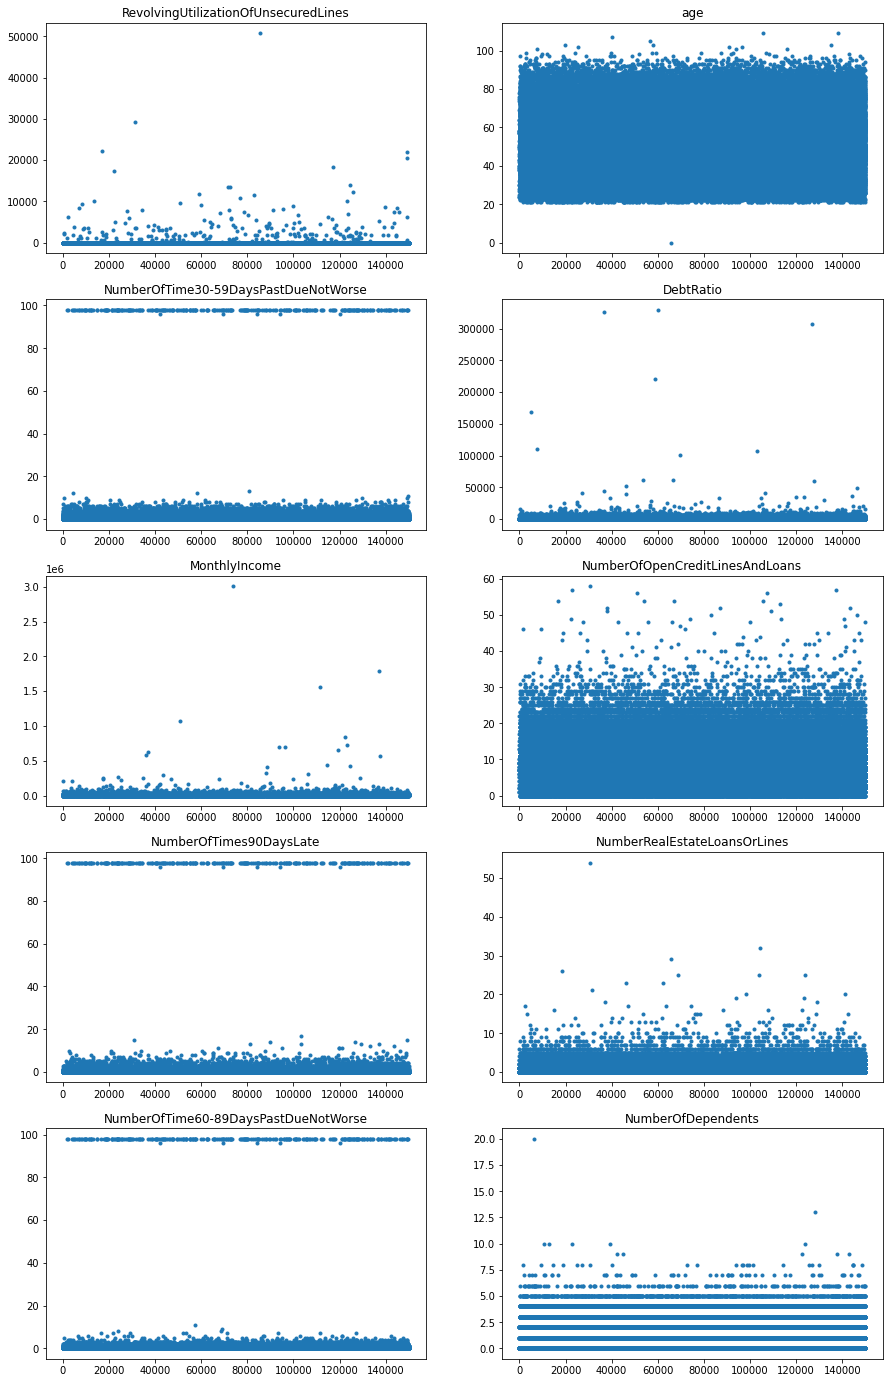

In [5]:
plot_axes(data=train)

### correlationship

<AxesSubplot:>

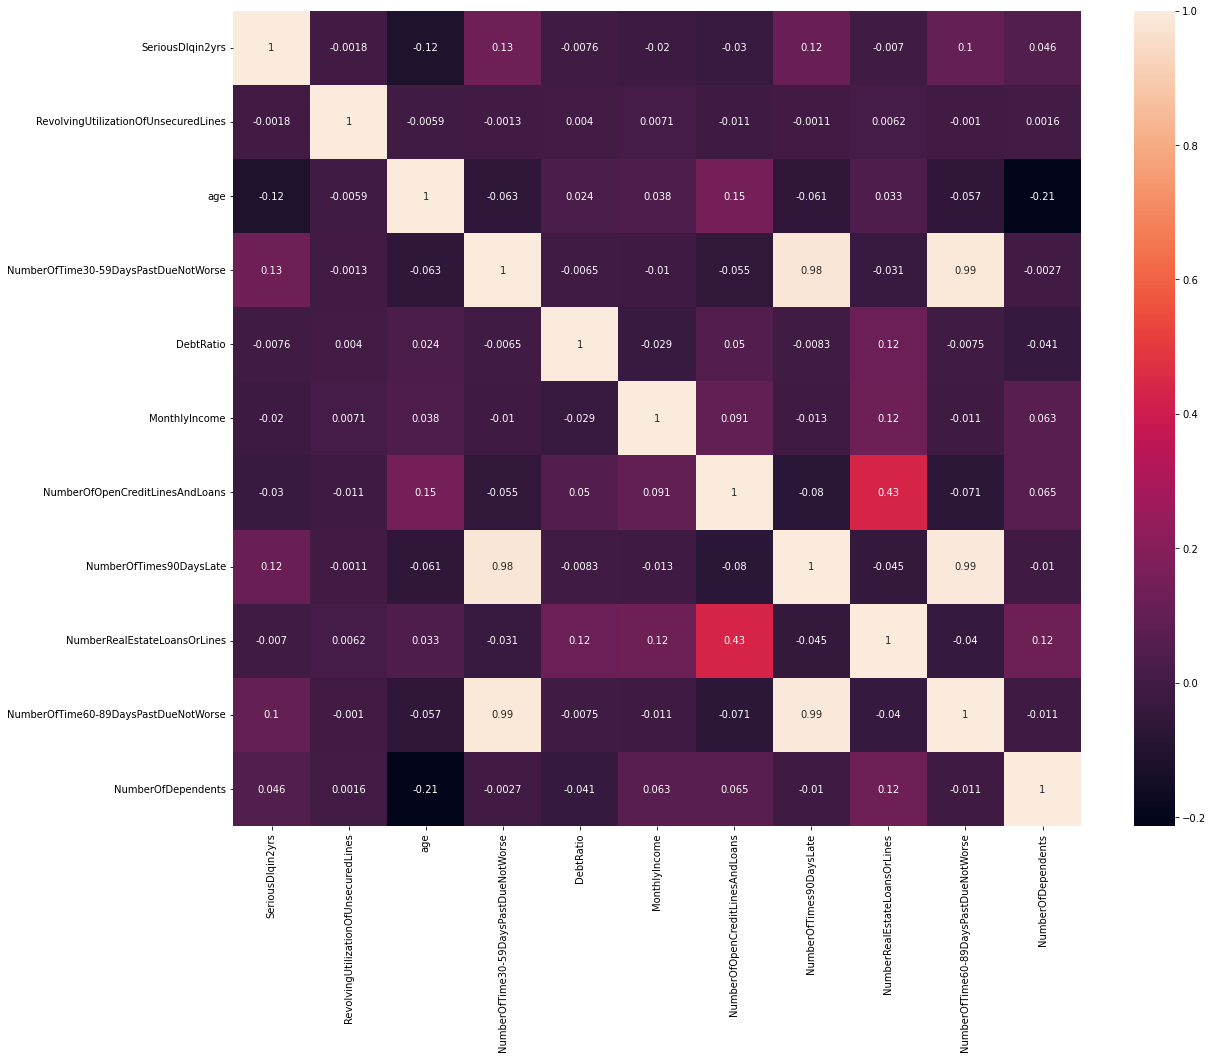

In [18]:
train = pd.read_csv('data/cs-training.csv',index_col = 0)
corr = train.corr()
plt.figure(figsize=(19,15))
sns.heatmap(corr,annot=True)

<AxesSubplot:>

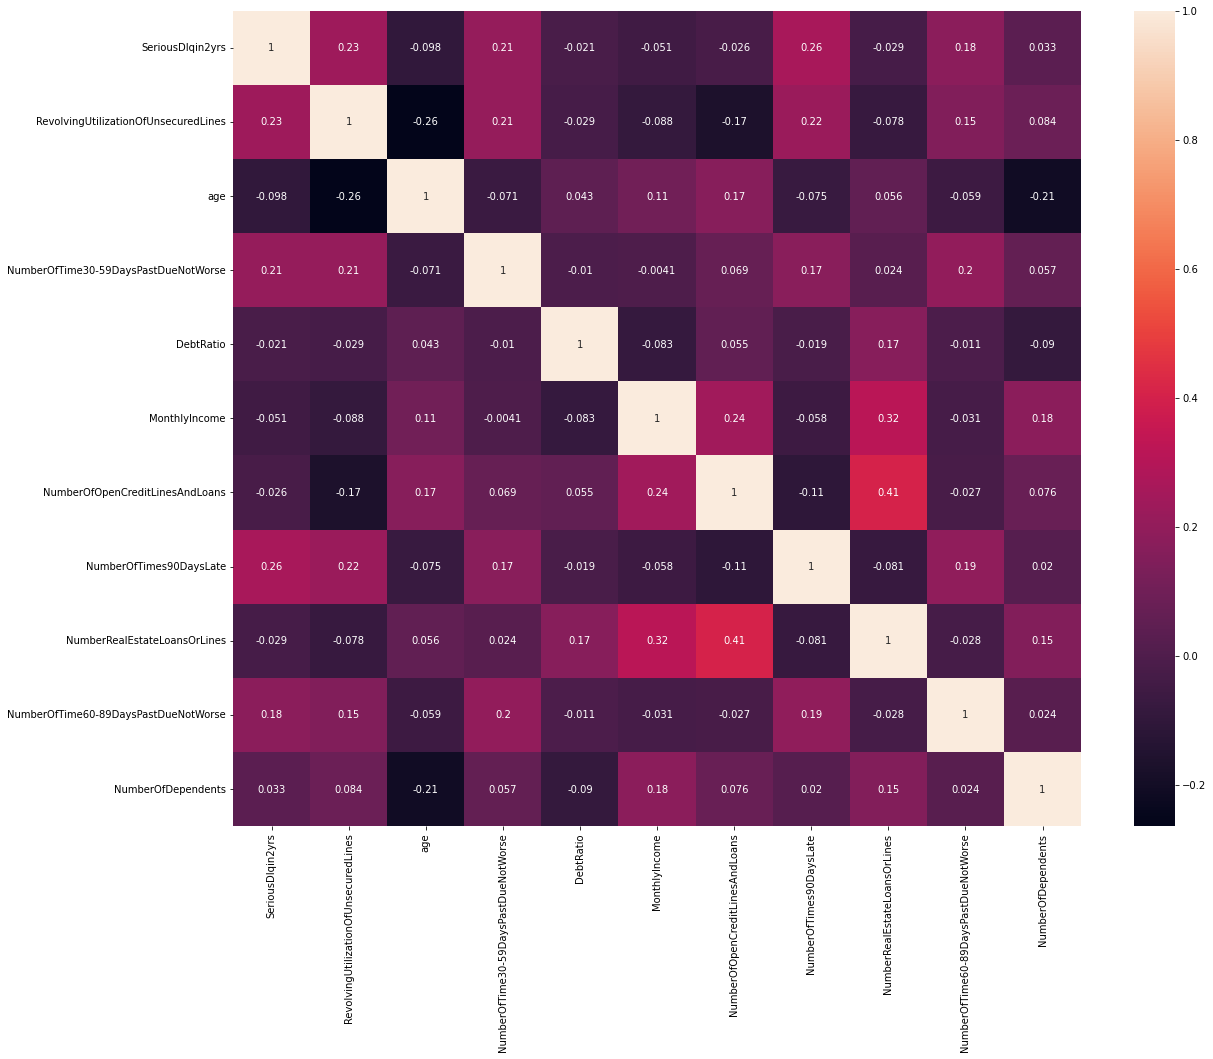

In [19]:
# clean the training data
train_data = pd.read_csv('data/cs-training.csv',index_col = 0)
train_data.drop_duplicates(inplace=True)
train_data.MonthlyIncome.fillna(value=train_data.MonthlyIncome.median(), inplace=True)
train_data = train_data.dropna()
train_data = train_data[train_data['NumberOfTime30-59DaysPastDueNotWorse'] <4.00]
train_data = train_data[train_data['NumberOfTime60-89DaysPastDueNotWorse'] <2.00]
train_data = train_data[train_data['NumberOfTimes90DaysLate'] <3.00]
train_data = train_data[train_data['RevolvingUtilizationOfUnsecuredLines'] < 1.09]
train_data = train_data[train_data['DebtRatio'] < 4979.04]
train_data = train_data[train_data['MonthlyIncome'] <25000.00]
train_data = train_data[train_data['NumberRealEstateLoansOrLines'] <4.00]
train_data = train_data[train_data['NumberOfDependents'] <4.00]
train_data = train_data[train_data['NumberOfOpenCreditLinesAndLoans'] <24.00]
train_data = train_data[train_data['age'] <87.00]
train_data = train_data[train_data['age'] > 0]
plt.figure(figsize=(19,15))
corr = train_data.corr()
sns.heatmap(corr, annot=True)

### interaction effects

In [24]:
train_data['AllNumlate']=train_data['NumberOfTime30-59DaysPastDueNotWorse']+train_data['NumberOfTime60-89DaysPastDueNotWorse']+train_data['NumberOfTimes90DaysLate']
train_data['Monthlypayment']=train_data['DebtRatio']*train_data['MonthlyIncome']

In [32]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})

        
        # Calculate the number of events in each group (bin)
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        
        # Calculate % of events in each group.
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()

        # Calculate the non events in each group.
        d['Non-Events'] = d['N'] - d['Events']
        # Calculate % of non events in each group.
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()

        # Calculate WOE by taking natural log of division of % of non-events and % of events
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [38]:
newDF, woeDF = iv_woe(train_data, 'SeriousDlqin2yrs', bins=10, show_woe=False)

Information value of RevolvingUtilizationOfUnsecuredLines is 0.954583
Information value of age is 0.225915
Information value of NumberOfTime30-59DaysPastDueNotWorse is 0.497987
Information value of DebtRatio is 0.06715
Information value of MonthlyIncome is 0.079507
Information value of NumberOfOpenCreditLinesAndLoans is 0.070593
Information value of NumberOfTimes90DaysLate is 0.578402
Information value of NumberRealEstateLoansOrLines is 0.04822
Information value of NumberOfTime60-89DaysPastDueNotWorse is 0.297154
Information value of NumberOfDependents is 0.022352
Information value of AllNumlate is 1.011722
Information value of Monthlypayment is 0.033102


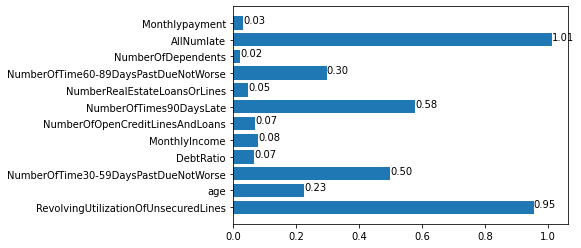

In [56]:
plt.barh(newDF['Variable'],newDF['IV'])
for x,y in enumerate(newDF['IV'].values): 
    plt.text(y, x, f'{y:.2f}')

### Part1:

1. The features: __"NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse"__ have high correlation with the probability of loan default in raw dataset. 
However, after feature engineering (delete outlier, fill NA, delete repeated value), the features: __"RevolvingUtilizationOfUnsecuredLines", "NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse"__ have high correlation with the probability of loan default in new dataset.

$ $

2. Make variable: 1. __"AllNumlate"__: the sum of [__"NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse"__] 2. __"Monthlypayment"__: the product of __"DebtRatio"__ and __"MonthlyIncome"__. 

    From the bar chart above, we can see that the IV (infomation value) of __"AllNumlate"__ is 1.01 which shows a significant influence on __"SeriousDlqin2yrs"__. However, the IV of __"Monthlypayment"__ is 0.03 which shows a low influence on __"SeriousDlqin2yrs"__.
    
 $ $
 
3.  In raw dataset, there are 19.56% NA in __"MonthlyIncome"__ and 2.56% NA in __"NumberOfDependents"__. To handle these NA, I applied mean and median to fill __"MonthlyIncome"__ and __"NumberOfDependents"__. I also tried to fill NA of __"MonthlyIncome"__ by assigning the median of different age groups to corrsponding groups, the "agegroup" are: 20y-30y, 30y-60y, >60y, and the median of these groups are 2780, 5833 and 5223. The AUC improves about 0.05% by applying "agegroup".

    In order to use XGBoost model, the extreme outlier should be cut off or shrunk to avoid the larger residuals in training. For example, there's a "0" in __"age"__ should be deleted and a lot of "98" and "96" are too large in __"NumberOfTimexxDaysPastDueNotWorse"__ variables. I shall shrink them to a relatively smaller value or delete them. There are some extreme outliers in __"DebtRatio" and "RevolvingUtilizationOfUnsecuredLines"__. I tried replace these outliers with 1 to eliminate the impact from extreme values.
    
    Delete some duplicate data in training dataset.
    
    

### Part 2

1. AUC is used to validate my XGBoost and LightGBM models, because AUC performs well when the propotion of 0 to 1 in this imbalanced data is about 14:1. AUC represents the area under the ROC curve. Higher the AUC, the better the model at correctly classifying instances. 

    In addition, I shall use F1 or PRAUC (Area Under the Precision-Recall Curve) as the evaluation metrix if the data is extremely imbalanced. In a ROC-AUC, the x-axis represents the FPR , and the y-axis represents the TPR. In a PRAUC, the x-axis is recall and y-axis is precision. If the dataset is highly imbalanced, true negatives (TN) in denominator results in false positive rate (FPR) being insensitive to changes in number of false positives (FP). On the other hand, precision is sensitive to changes in finding all positive examples (TP) without marking any negative examples positive (FP). So, in cases such as highly imbalanced datasets we prefer PR-AUC over ROC-AUC.

$$TPR = \frac{TP}{TP + FN}$$
$$FPR = \frac{FP}{TN + FP}$$

$$ Precision = \frac{TP}{TP + FP}$$
$$ Recall = \frac{TP}{TP + FN}$$ 

![title](graph1.png)



$ $

2. Data: First, I tried to fill NA of __"MonthlyIncome"__ by assigning the median of different age groups to corrsponding groups, the "agegroup" are: 20y-30y, 30y-60y, >60y, and the median of these groups are 2780, 5833 and 5223. The AUC improves about 0.05% by applying "agegroup". Second, the NA in __"NumberOfDependents"__ is replaced by median. Third, the high value in __"NumberOfTimesxxDaysLate"__ (like 98, 96) are shrunk to about 20. Lastly, I tried to cut off the extreme outliers. There's no change in final result. 

    Model: I tried LightGBM and XGBoost models for training, because boosting model can handle the problems (imbalanced data, missing value) in this dataset very well. LightGBM is trained faster than XGBoost but has relatively lower AUC. So I choose XGBoost as my prediction model. LightGBM has 86.2% AUC and XGBoost has 86.5% without processing any data.

    Features: I tried to use products and sum of some features like: __"NumberOfTimexxDaysPastDueNotWorse", "MonthlyIncome"__, to add more information and nonlinear features. However, the new features do not bring higher AUC results. Then, I tried to generate one hundred different  variables of sum and product of every features, which improves about 1% AUC to 87.5% in training data. 

$ $

3. Insights: I think no matter what project we are working on, completely knowing your data always comes first. We should choose a model after completely understanding what the data structure and features are. A selection of suitable model is important as well because there's no perfect model except a suitable model. Additionally, the tuning of parameters also has large impact of result. The gap between worst parameters and best parameters may reach 5% in XGBoost model. 

    The set of paramteters is crutial and the searching of optimal parameters is the most time-consuming.

$ $

4. Leaderboard: the result is: 0.86234 in public score (rank: __39__)